# Setup

In [4]:
from utils import plot
from helpers import make_data, score_iou

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

IMAGE_SIZE = 200
NOISE_LEVEL = 0.8
MAX_WIDTH = 37
MAX_HEIGHT = MAX_WIDTH * 2
SCALE_VECTOR = [IMAGE_SIZE, IMAGE_SIZE, 2 * np.pi, MAX_WIDTH, MAX_HEIGHT]

In [5]:
def preprocess_image(img):
    return np.where(img >= NOISE_LEVEL, img, 0.0)

# Dataset

In [6]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [7]:
class RegressionDataset(Dataset):
    def __init__(self, N):
        self.N = N
    
    def __len__(self):
        return self.N

    def __getitem__(self, index):
        if index >= self.N:
            raise StopIteration

        image, label = make_data(has_spaceship=True)
        image = preprocess_image(image)
        label = label / SCALE_VECTOR
        return np.float32(image), np.float32(label)

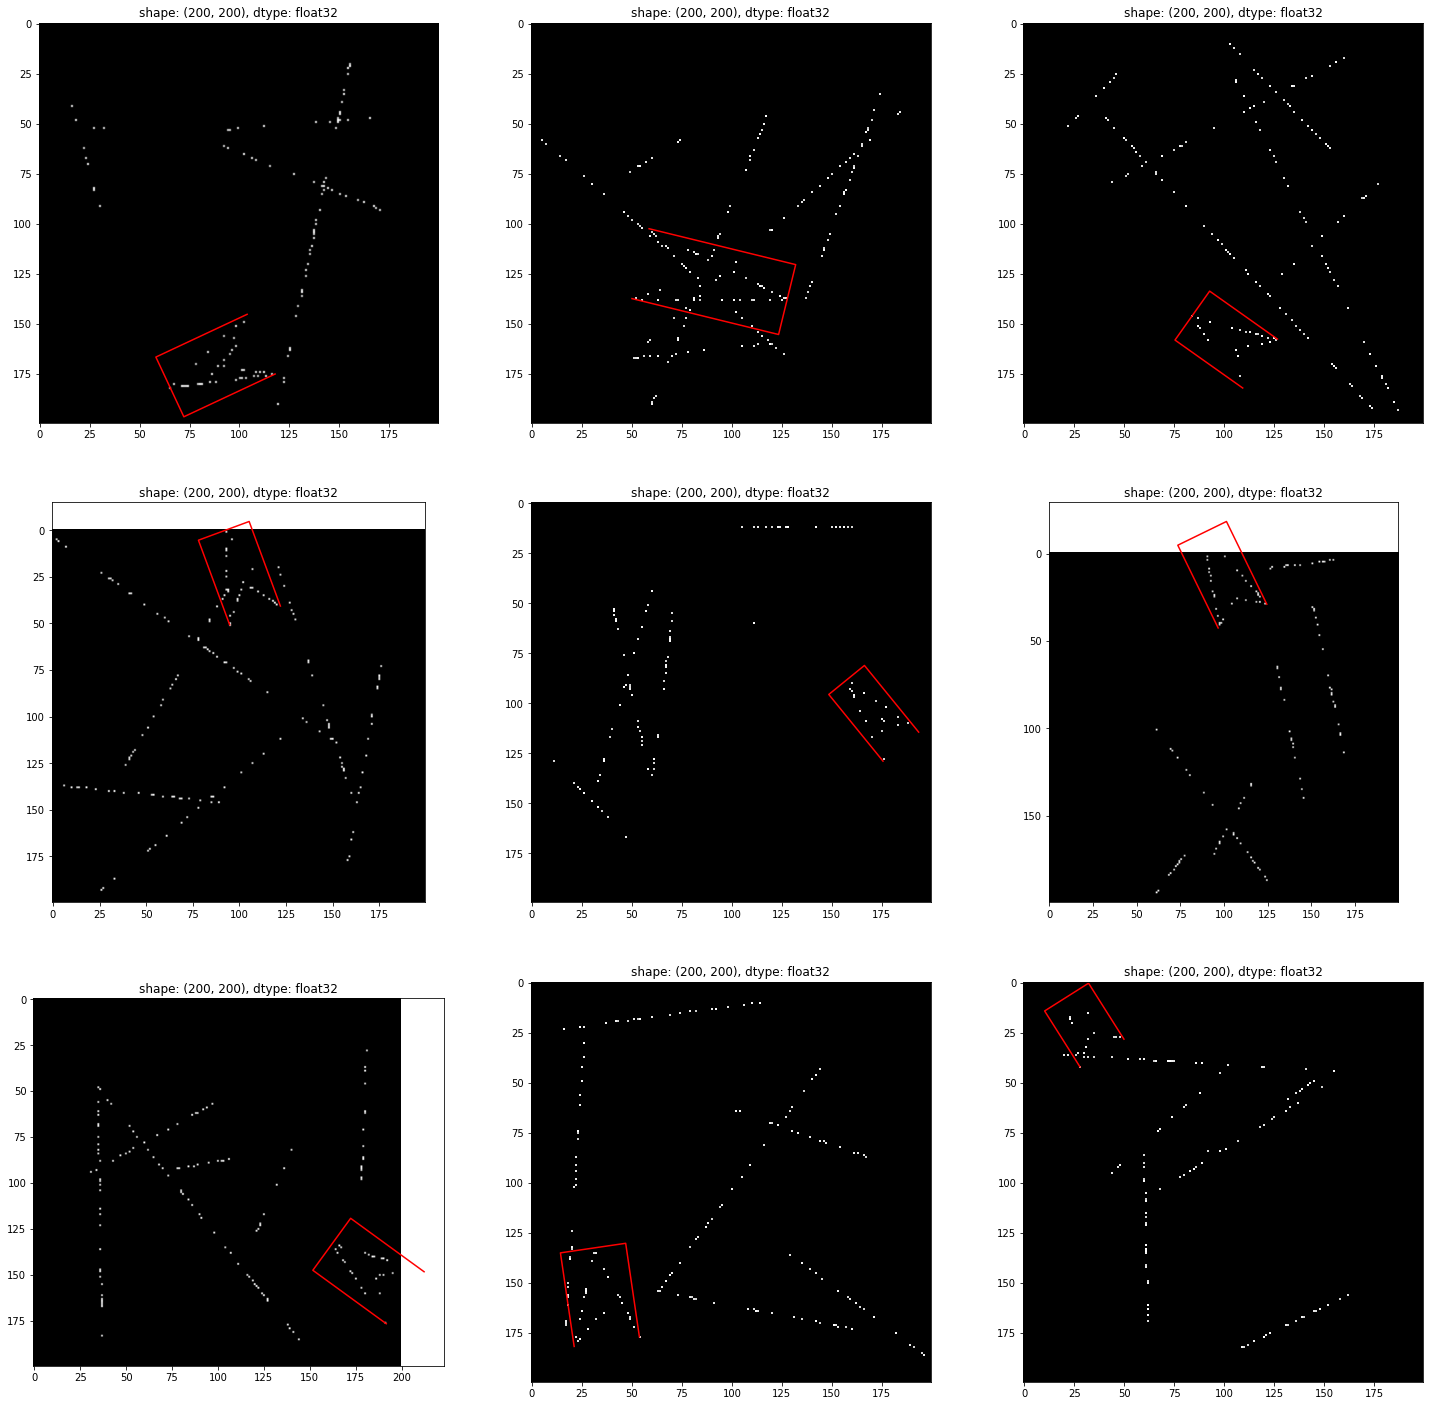

In [8]:
dataset = RegressionDataset(9)

fig, ax = plt.subplots(3, 3, figsize=(25, 25))
for i, (image, label) in enumerate(dataset):
    plot(ax[i//3][i%3], image, label*SCALE_VECTOR, f"shape: {image.shape}, dtype: {image.dtype}", make_dot=False)

# Data Module

In [9]:
class DataModule(pl.LightningDataModule):
    def __init__(self, n_train_examples, n_val_examples, batch_size):
        super().__init__()
        self.n_train_examples = n_train_examples
        self.n_val_examples = n_val_examples
        self.batch_size = batch_size

    def setup(self, stage):
        if stage == "fit":
            self.train_dataset = RegressionDataset(self.n_train_examples)
            self.val_dataset = RegressionDataset(self.n_val_examples)
        else:
            self.test_dataset = RegressionDataset(self.n_val_examples)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [10]:
dm = DataModule(10000, 1000, 64)
dm.setup("fit")

for batch in dm.train_dataloader():
    images, labels = batch
    print(type(images), images.dtype, images.shape)
    print(type(images), images.dtype, images.unsqueeze(1).shape)
    print(type(labels), images.dtype, labels.shape)
    break

<class 'torch.Tensor'> torch.float32 torch.Size([64, 200, 200])
<class 'torch.Tensor'> torch.float32 torch.Size([64, 1, 200, 200])
<class 'torch.Tensor'> torch.float32 torch.Size([64, 5])


# Model

In [11]:
class RegressionModel(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr
        self.model = self.init_model()
        self.criterion = torch.nn.MSELoss()
        self.accuracy = pl.metrics.Accuracy()

    def init_model(self):
        model = torch.nn.Sequential()
        
        in_channels = 1
        conv_layers_params = [(8, 11), (16, 9), (32, 7), (64, 5), (128, 3), (256, 3), (512, 3)]
        for i, (nfilters, kernel_size) in enumerate(conv_layers_params):
            model.add_module(
                f"conv2d_{i}",
                torch.nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=nfilters,
                    kernel_size=kernel_size,
                    padding=(kernel_size - 1) // 2  # same padding, stride and dilation must be 1
                ),
            )
            model.add_module(f"relu_{i}", torch.nn.ReLU())
            model.add_module(f"max_pool_2d_{i}", torch.nn.MaxPool2d(2, 2))
            model.add_module(
                f"batch_normalization_{i}", 
                torch.nn.BatchNorm2d(nfilters, eps=0.001, momentum=0.01)
            )
            in_channels = nfilters

        model.add_module("flatten", torch.nn.Flatten())
        model.add_module("linear", torch.nn.Linear(512, 5))
        model.add_module(f"sigmoid", torch.nn.Sigmoid())

        return model

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, images):
        images = images.unsqueeze(1)
        outputs = self.model(images)
        outputs = outputs.squeeze()
        return outputs

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        loss = self.criterion(outputs, labels)

        self.log("train_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)

        preds = [pred * SCALE_VECTOR for pred in outputs.detach().cpu().numpy()]
        targets = [label * SCALE_VECTOR for label in labels.detach().cpu().numpy()]

        ious = np.array([score_iou(pred, target) for pred, target in zip(preds, targets)])
        metrics = {
            "val_loss": self.criterion(outputs, labels).item(),
            "mean_iou": ious.mean(),
            "score": (ious > 0.7).mean()
        }
        for k, v in metrics.items():
            self.log(k, v, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, *args, **kwargs):
        return self.validation_step(*args, **kwargs)
    
    def predict(self, images):
        outputs = self.forward(images).detach().cpu().numpy() 
        preds = [pred * SCALE_VECTOR for pred in outputs]
        preds = np.asarray(preds)
        return preds


In [12]:
model = RegressionModel().cuda()

print(model)
summary(model, (200, 200), device="cuda")

RegressionModel(
  (model): Sequential(
    (conv2d_0): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (relu_0): ReLU()
    (max_pool_2d_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_0): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_1): Conv2d(8, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu_1): ReLU()
    (max_pool_2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu_2): ReLU()
    (max_pool_2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_3): Conv2d(32, 64, kern

# Main

In [13]:
dm = DataModule(8000, 1024, 8)

model = RegressionModel().cuda()

print(model)
summary(model, (200, 200), device="cuda")

RegressionModel(
  (model): Sequential(
    (conv2d_0): Conv2d(1, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (relu_0): ReLU()
    (max_pool_2d_0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_0): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_1): Conv2d(8, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu_1): ReLU()
    (max_pool_2d_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu_2): ReLU()
    (max_pool_2d_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batch_normalization_2): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv2d_3): Conv2d(32, 64, kern

In [19]:
trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    progress_bar_refresh_rate=20,
)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 1.6 M 
1 | criterion | MSELoss    | 0     
2 | accuracy  | Accuracy   | 0     
-----------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params


1

In [20]:
trainer.test()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'mean_iou': tensor(0.5192),
 'score': tensor(0.1123),
 'val_loss': tensor(0.0069)}
--------------------------------------------------------------------------------


[{'mean_iou': 0.5191622972488403,
  'score': 0.1123046875,
  'val_loss': 0.006916813086718321}]

In [25]:
batch_size = 128
num_examples = 10000

images, labels = zip(
    *[make_data() for _ in tqdm(range(num_examples), desc="creating data")]
)
images = [preprocess_image(img) for img in tqdm(images, desc="preprocessing")]

predictions = []
for i in tqdm(range(0, len(images), batch_size)):
    inputs = images[i:i+batch_size]
    inputs = np.stack(inputs)
    inputs = np.float32(inputs)
    inputs = torch.from_numpy(inputs).to(model.device)
    predictions.extend(model.predict(inputs))

100%|██████████| 79/79 [00:04<00:00, 19.20it/s]


In [27]:
predictions = np.stack(predictions)
ious = [score_iou(label, pred) for pred, label in zip(predictions, labels)]
ious = np.asarray(ious, dtype="float")
ious = ious[~np.isnan(ious)]  # remove true negatives
score = (ious > 0.7).mean()
score

0.0542

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


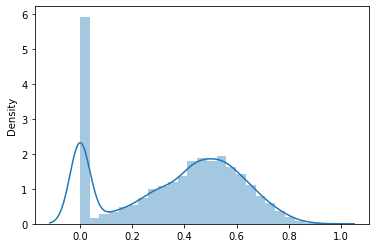

In [28]:
import seaborn as sns
sns.distplot(ious)